In [1]:
!nvidia-smi

Sat Dec 28 02:34:06 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:06:00.0 Off |                    0 |
| N/A   43C    P0             71W /  300W |   31457MiB /  32768MiB |     31%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

# Fine Tuning Tiny LLM on Custom Dataset

1. Tiny-LLM membutuhkan resource lebih sedikit dibanding LLM yang large

2. Kontrol akan prompt dan format output

3. Tidak perlu ada proses transformasi format seperti klasik ML

4. Kita bisa minta Tiny-LLM untuk men-generate output ke format JSON, Markdown, Yaml, dll

In [25]:
import inspect
import random
import sqlite3

import torch
import numpy as np
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datasets import Dataset
from pylab import rcParams
from pytorch_lightning import seed_everything
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from trl import DataCollatorForCompletionOnlyLM, SFTTrainer
 
%matplotlib inline
%config InlineBackend.figure_format='retina'
 
COLORS = ["#bae1ff", "#ffb3ba", "#ffdfba", "#ffffba", "#baffc9"]
 
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
sns.set_palette(sns.color_palette(COLORS))
 
cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", COLORS[:2])
 
MY_STYLE = {
    "figure.facecolor": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "axes.linewidth": 0.5,
    "text.color": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "gray",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "axes.grid": True,
    "xtick.labelsize": "medium",
    "ytick.labelsize": "medium",
    "axes.titlesize": "large",
    "axes.labelsize": "large",
    "lines.color": COLORS[0],
    "patch.edgecolor": "white",
}
 
mpl.rcParams.update(MY_STYLE)
 
SEED = 42
 
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
 
seed_everything(SEED)

## Prepare Dataset

In [8]:
import pandas as pd
import ast

def process_sentiment_csv(df):
    """
    Process DataFrame to split sentiment JSON into separate columns
    """
    def parse_sentiment(x):
        try:
            if isinstance(x, str) and "'" in x:  # Check if it's a string representation of dict
                data = ast.literal_eval(x)
                return pd.Series({
                    'sentiment': data.get('class', ''),
                    'polarity': float(data.get('polarity', 0.0)),
                    'subjectivity': float(data.get('subjectivity', 0.0))
                })
            else:
                return pd.Series({'sentiment': x, 'polarity': None, 'subjectivity': None})
        except Exception as e:
            print(f"Error parsing: {x}")
            print(f"Error message: {str(e)}")
            return pd.Series({'sentiment': None, 'polarity': None, 'subjectivity': None})
    
    # Split the sentiment column
    sentiment_df = df['sentiment'].apply(parse_sentiment)
    
    # Drop the original sentiment column and join the new columns
    result = df.drop('sentiment', axis=1).join(sentiment_df)
    
    # Reorder columns to match desired output
    desired_order = ['date', 'subject', 'text', 'title', 'sentiment', 'polarity', 'subjectivity']
    available_columns = [col for col in desired_order if col in result.columns]
    result = result[available_columns]
    
    return result

In [9]:
df = pd.read_csv("cryptonews.csv")
df.head()

,date,sentiment,source,subject,text,title,url
0,2023-12-19 06:40:41,"{'class': 'negative', 'polarity': -0.1, 'subje...",CryptoNews,altcoin,Grayscale CEO Michael Sonnenshein believes the...,Grayscale CEO Calls for Simultaneous Approval ...,https://cryptonews.comhttps://cryptonews.com/n...
1,2023-12-19 06:03:24,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,blockchain,"In an exclusive interview with CryptoNews, Man...",Indian Government is Actively Collaborating Wi...,https://cryptonews.comhttps://cryptonews.com/n...
2,2023-12-19 05:55:14,"{'class': 'positive', 'polarity': 0.05, 'subje...",CryptoNews,blockchain,According to the Federal Court ruling on Decem...,Judge Approves Settlement: Binance to Pay $1.5...,https://cryptonews.comhttps://cryptonews.com/n...
3,2023-12-19 05:35:26,"{'class': 'positive', 'polarity': 0.5, 'subjec...",CoinTelegraph,blockchain,Some suggest EVM inscriptions are the latest w...,Why a gold rush for inscriptions has broken ha...,https://cointelegraph.com/news/inscriptions-ev...
4,2023-12-19 05:31:08,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CoinTelegraph,ethereum,A decision by bloXroute Labs to start censorin...,‘Concerning precedent’ — bloXroute Labs' MEV r...,https://cointelegraph.com/news/concerning-prec...


In [10]:
df = process_sentiment_csv(df)
df.head()

,date,subject,text,title,sentiment,polarity,subjectivity
0,2023-12-19 06:40:41,altcoin,Grayscale CEO Michael Sonnenshein believes the...,Grayscale CEO Calls for Simultaneous Approval ...,negative,-0.10,0.60
1,2023-12-19 06:03:24,blockchain,"In an exclusive interview with CryptoNews, Man...",Indian Government is Actively Collaborating Wi...,neutral,0.00,0.00
2,2023-12-19 05:55:14,blockchain,According to the Federal Court ruling on Decem...,Judge Approves Settlement: Binance to Pay $1.5...,positive,0.05,0.05
3,2023-12-19 05:35:26,blockchain,Some suggest EVM inscriptions are the latest w...,Why a gold rush for inscriptions has broken ha...,positive,0.50,0.90
4,2023-12-19 05:31:08,ethereum,A decision by bloXroute Labs to start censorin...,‘Concerning precedent’ — bloXroute Labs' MEV r...,neutral,0.00,0.00


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31037 entries, 0 to 31036
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          31037 non-null  object 
 1   subject       31037 non-null  object 
 2   text          31037 non-null  object 
 3   title         31037 non-null  object 
 4   sentiment     31037 non-null  object 
 5   polarity      31037 non-null  float64
 6   subjectivity  31037 non-null  float64
dtypes: float64(2), object(5)
memory usage: 1.7+ MB


In [12]:
from sklearn.model_selection import train_test_split

train_df, temp = train_test_split(df, stratify=df['sentiment'], test_size=0.2)

In [13]:
val_df, test_df = train_test_split(temp, stratify=temp['sentiment'], test_size=0.5)

In [14]:
train_df.shape, val_df.shape, test_df.shape

((24829, 7), (3104, 7), (3104, 7))

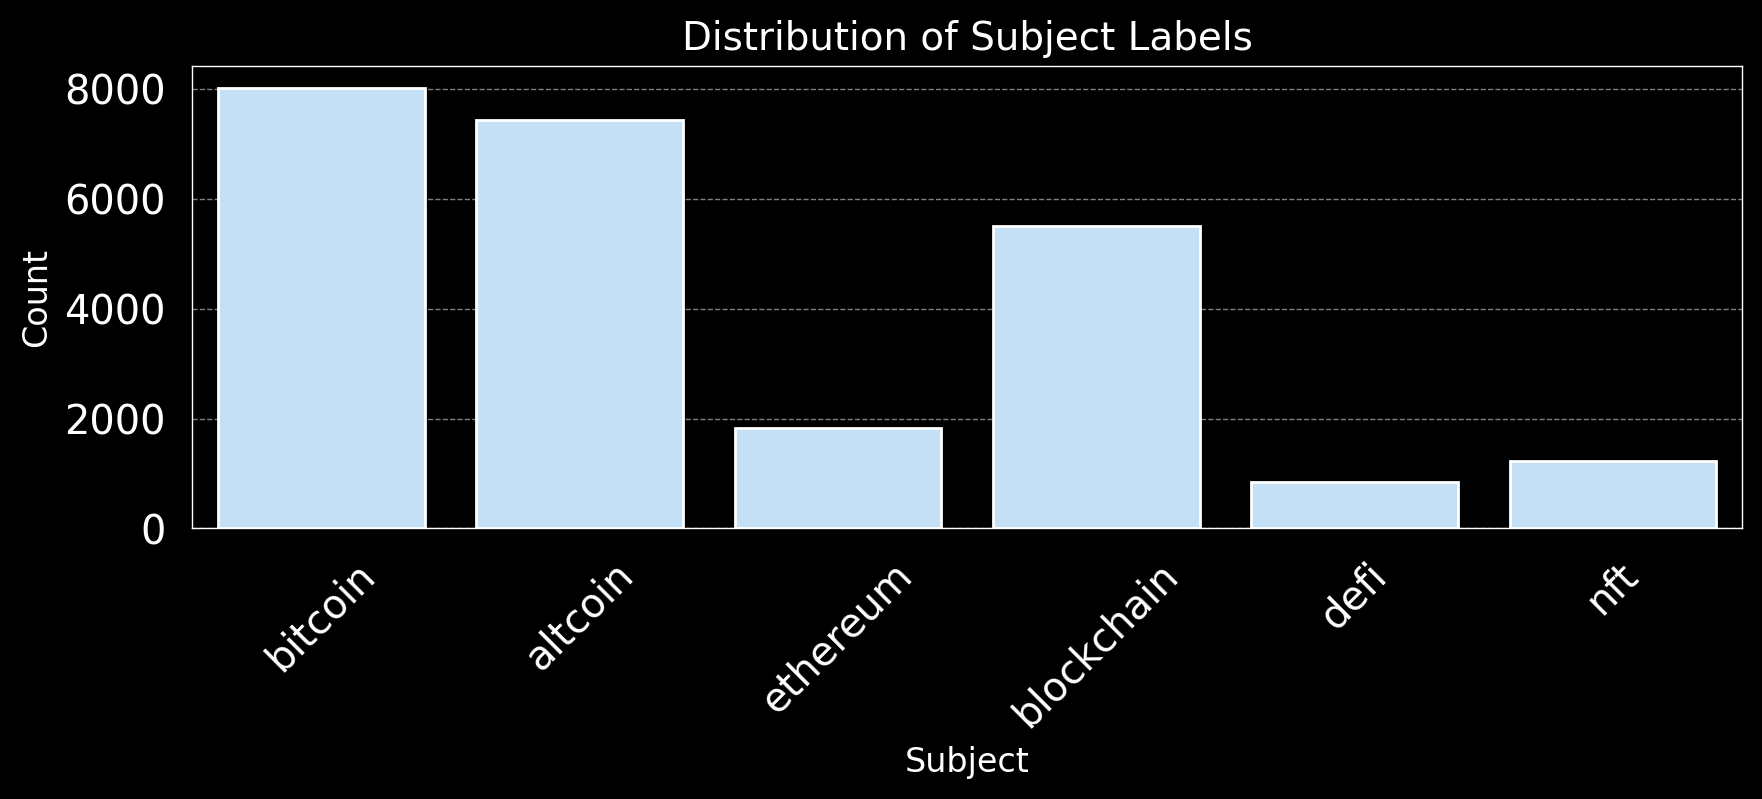

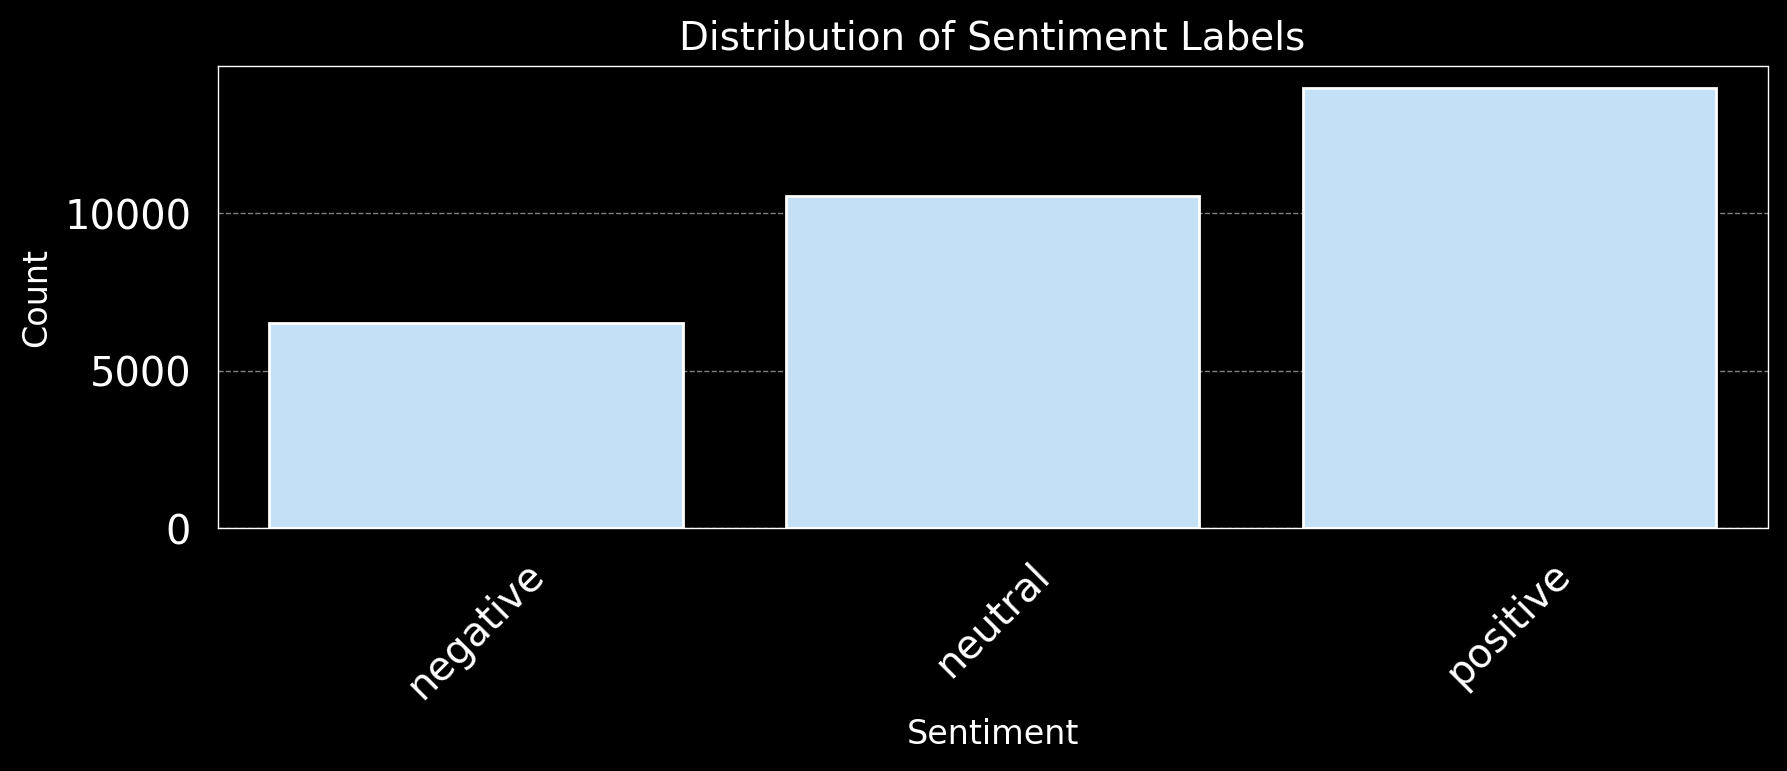

In [15]:
plt.figure(figsize=(10, 3))
sns.countplot(data=train_df, x="subject")
plt.title("Distribution of Subject Labels", fontsize=14)
plt.xlabel("Subject", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Plot distribution of 'sentiment'
plt.figure(figsize=(10, 3))
sns.countplot(data=df, x="sentiment")
plt.title("Distribution of Sentiment Labels", fontsize=14)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.show()


In [16]:
dataset = {
    "train": Dataset.from_pandas(train_df),
    "val": Dataset.from_pandas(val_df),
    "test": Dataset.from_pandas(test_df),
}
dataset

{'train': Dataset({
     features: ['date', 'subject', 'text', 'title', 'sentiment', 'polarity', 'subjectivity', '__index_level_0__'],
     num_rows: 24829
 }),
 'val': Dataset({
     features: ['date', 'subject', 'text', 'title', 'sentiment', 'polarity', 'subjectivity', '__index_level_0__'],
     num_rows: 3104
 }),
 'test': Dataset({
     features: ['date', 'subject', 'text', 'title', 'sentiment', 'polarity', 'subjectivity', '__index_level_0__'],
     num_rows: 3104
 })}

## Fine-tuning

In [14]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
 
MODEL_NAME = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"
PAD_TOKEN = "<pad>"
 
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    add_eos_token=True,
    use_fast=True
)

# tokenizer secara default ga punya padding token, jadi kita tambahkan padding token nya
tokenizer.add_special_tokens({"pad_token": PAD_TOKEN})
tokenizer.padding_side = "right"

In [15]:
tokenizer.pad_token, tokenizer.pad_token_id

('<pad>', 32000)

In [16]:
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    trust_remote_code=True,
    # attn_implementation="flash_attention_2" if available
)
model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)
model.pad_token_id = tokenizer.pad_token_id
model.config.pad_token_id = tokenizer.pad_token_id

In [17]:
model.config

LlamaConfig {
  "_name_or_path": "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5632,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 22,
  "num_key_value_heads": 4,
  "pad_token_id": 32000,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "float32",
  "transformers_version": "4.45.2",
  "use_cache": true,
  "vocab_size": 32008
}

In [18]:
def format_example(example):
    return inspect.cleandoc(
        f"""
### Title:
{example["title"]}
### Text:
{example["text"]}
### Prediction:
subject: {example["subject"]}
sentiment: {example["sentiment"]}
"""
    )
 
print(format_example(dataset["train"][0]))

### Title:
This simple Bitcoin options strategy allows traders to go long with limited downside risk
### Text:
Bullish on Bitcoin but afraid of futures liquidations? Here is how pro traders use options to cast safer bets.
### Prediction:
subject: bitcoin
sentiment: negative


In [19]:
token_counts = []
for example in dataset["train"]:
    token_counts.append(
        len(
            tokenizer(
                format_example(example),
                add_special_tokens=True,
                return_attention_mask=False,
            )["input_ids"]
        )
    )

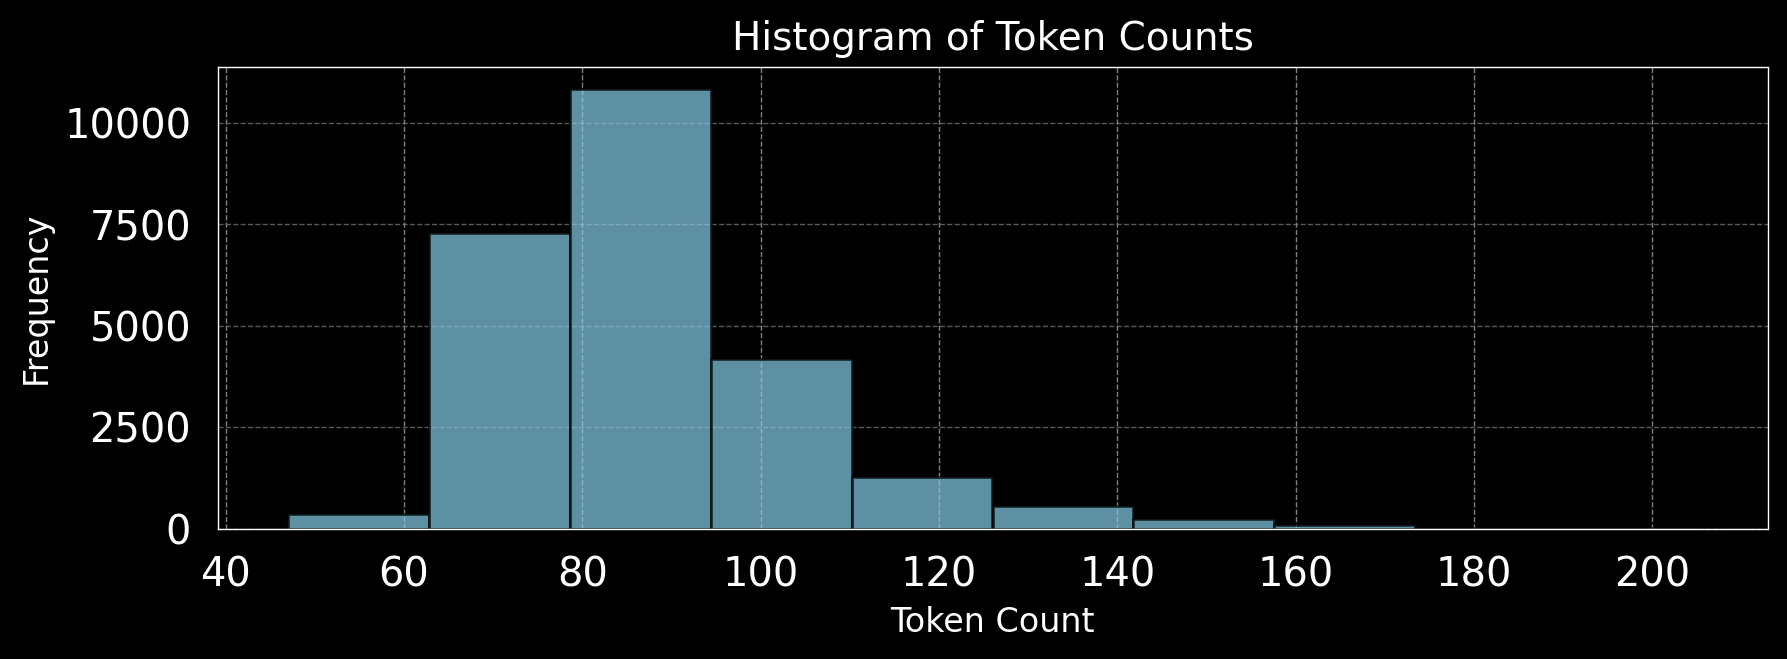

In [52]:
plt.figure(figsize=(10, 3))
plt.hist(token_counts, bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Token Counts', fontsize=14)
plt.xlabel('Token Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Fine-tuning with LoRA (Low Rank Adaptation)

In [20]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32008, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): 

In [21]:
from peft import LoraConfig, TaskType, get_peft_model

lora_config = LoraConfig(
    r=128,
    lora_alpha=128,
    target_modules=[
        "self_attn.q_proj",
        "self_attn.k_proj",
        "self_attn.v_proj",
        "self_attn.o_proj",
        "mlp.gate_proj",
        "mlp.up_proj",
        "mlp.down_proj",
    ],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)
 
model = get_peft_model(model, lora_config)
 
model.print_trainable_parameters()

trainable params: 100,925,440 || all params: 1,201,006,592 || trainable%: 8.4034


### Training on Completions

In [22]:
response_template = "\n### Prediction:"
response_template_ids = tokenizer.encode(
    response_template, add_special_tokens=False
)[2:]
collator = DataCollatorForCompletionOnlyLM(response_template_ids, tokenizer=tokenizer)
 
examples = [format_example(dataset["train"][0])]
encodings = [tokenizer(e) for e in examples]
 
dataloader = DataLoader(encodings, collate_fn=collator, batch_size=1)
batch = next(iter(dataloader))
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [23]:
batch["labels"]

tensor([[ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,    13, 16009, 29901,  2586,  1111,
           262,    13, 18616,  2073, 29901,  8178,     2]])

In [24]:
from transformers import TrainingArguments
 
training_arguments = TrainingArguments(
    output_dir="experiments",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    optim="adamw_torch",
    evaluation_strategy="steps",
    eval_steps=0.2,
    logging_steps=10,
    learning_rate=1e-4,
    fp16=True,
    save_strategy="epoch",
    max_grad_norm=1.0,
    lr_scheduler_type="constant",
    report_to="tensorboard",
    save_safetensors=True,
    seed=SEED,
)

/workspace/mlexpert/env/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [25]:
def format_prompts(example):
    output_texts = []
    for i in range(len(example["title"])):
        text = inspect.cleandoc(
            f"""
### Title:
{example["title"][i]}
### Text:
{example["text"][i]}
### Prediction:
subject: {example["subject"][i]}
sentiment: {example["sentiment"][i]}
"""
        )
        output_texts.append(text)
    return output_texts

In [26]:
from trl import SFTTrainer, SFTConfig
 
trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
    tokenizer=tokenizer,
    max_seq_length=1024,
    formatting_func=format_prompts,
    data_collator=collator,
)

/workspace/mlexpert/env/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/workspace/mlexpert/env/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/workspace/mlexpert/env/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/24829 [00:00<?, ? examples/s]

Map:   0%|          | 0/3104 [00:00<?, ? examples/s]

In [27]:
trainer.train()

Step,Training Loss,Validation Loss
311,0.129300,0.138328
622,0.109600,0.098994
933,0.088800,0.085925
1244,0.079000,0.081672


/workspace/mlexpert/env/lib/python3.10/site-packages/peft/utils/save_and_load.py:257: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/workspace/mlexpert/env/lib/python3.10/site-packages/peft/utils/save_and_load.py:257: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


TrainOutput(global_step=1552, training_loss=0.11223125279180168, metrics={'train_runtime': 1689.5357, 'train_samples_per_second': 14.696, 'train_steps_per_second': 0.919, 'total_flos': 1.781599185967104e+16, 'train_loss': 0.11223125279180168, 'epoch': 1.0})

In [28]:
trainer.model.save_pretrained("crypto-sentiment-model")
tokenizer.save_pretrained("crypto-sentiment-model")

/workspace/mlexpert/env/lib/python3.10/site-packages/peft/utils/save_and_load.py:257: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


('crypto-sentiment-model/tokenizer_config.json',
 'crypto-sentiment-model/special_tokens_map.json',
 'crypto-sentiment-model/tokenizer.json')

## Evaluation

In [17]:
import torch
from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer
 
MODEL_NAME = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"
 
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    torch_dtype=torch.float16,
)
tokenizer = AutoTokenizer.from_pretrained(
    "crypto-sentiment-model", add_eos_token=False
)

base_model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)
base_model.pad_token_id = tokenizer.pad_token_id

model = PeftModel.from_pretrained(base_model, "crypto-sentiment-model")
model = model.merge_and_unload()
 
tokenizer.pad_token, tokenizer.pad_token_id, tokenizer.padding_side

('<pad>', 32000, 'right')

In [18]:
model.config.pad_token_id = tokenizer.pad_token_id

model.pad_token_id, model.config.pad_token_id

(32000, 32000)

In [19]:
from transformers import pipeline, logging
 
pipe = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=16,
    return_full_text=False,
)
 
logging.set_verbosity(logging.CRITICAL)

In [20]:
def format_for_prediction(example):
    return inspect.cleandoc(
        f"""
### Title:
{example["title"]}
### Text:
{example["text"]}
### Prediction:
"""
    )

In [21]:
for i in range(3):
    example = dataset["test"][i]
    print(f"Example {i + 1}\n")
    text = inspect.cleandoc(
        f"""
        Title: {example["title"]}
        Text: {example["text"]}
        Subject: {example["subject"]}
        Sentiment: {example["sentiment"]}
    """
    )
    print(text)
    print("\nPrediction:")
    outputs = pipe(format_for_prediction(example))
    print(outputs[0]["generated_text"])
    print()

Example 1

Title: Canadian Bitcoin ETF adds 6.9K BTC in one day as GBTC discount hits record low
Text: It's a polarizing world in institutional Bitcoin offerings this week as Grayscale's CEO remains convinced demand will return.
Subject: bitcoin
Sentiment: neutral

Prediction:

subject: bitcoin
sentiment: neutral

Example 2

Title: Bank of England's CBDC 'Britcoin' May Not Rely on Blockchain
Text: The Bank of England is still mulling over which technology will underpin its Central Bank-Backed Digital Currency. Read on to learn more.
Subject: blockchain
Sentiment: positive

Prediction:

subject: blockchain
sentiment: positive

Example 3

Title: Bitcoin Depot says SPAC merger will continue as planned after solid revenue growth
Text: The firm's revenue increased by 25.25% to $497.2 million in the first nine months of 2022.
Subject: blockchain
Sentiment: positive

Prediction:

subject: bitcoin
sentiment: positive



In [22]:
import re
 
from tqdm import tqdm
 
rows = []
 
for i in tqdm(range(len(dataset["test"]))):
    example = dataset["test"][i]
    outputs = pipe(format_for_prediction(example))
    text = outputs[0]["generated_text"]
    parts = re.split(r"[:\n]", text.strip())
    subject, sentiment = parts[1].strip(), parts[3].strip()
 
    rows.append(
        {
            "title": example["title"],
            "text": example["text"],
            "true_subject": example["subject"],
            "true_sentiment": example["sentiment"],
            "pred_subject": subject,
            "pred_sentiment": sentiment,
        }
    )
predictions_df = pd.DataFrame(rows)
predictions_df.head()

100%|██████████████████████████████████████████████████████████| 3104/3104 [19:04<00:00,  2.71it/s]


,title,text,true_subject,true_sentiment,pred_subject,pred_sentiment
0,Canadian Bitcoin ETF adds 6.9K BTC in one day ...,It's a polarizing world in institutional Bitco...,bitcoin,neutral,bitcoin,neutral
1,Bank of England's CBDC 'Britcoin' May Not Rely...,The Bank of England is still mulling over whic...,blockchain,positive,blockchain,positive
2,Bitcoin Depot says SPAC merger will continue a...,The firm's revenue increased by 25.25% to $497...,blockchain,positive,bitcoin,positive
3,6 Years in Prison for Arizona Entrepreneur for...,Former Co-Owner of Minnesota Vikings' acquisit...,altcoin,neutral,altcoin,neutral
4,5 signs that an altcoin bull run could be unde...,Record-low volatility and potentially positive...,bitcoin,positive,bitcoin,positive


### Error Analysis

In [26]:
(predictions_df["true_subject"] == predictions_df["pred_subject"]).sum() / len(
    predictions_df
)

0.7731958762886598

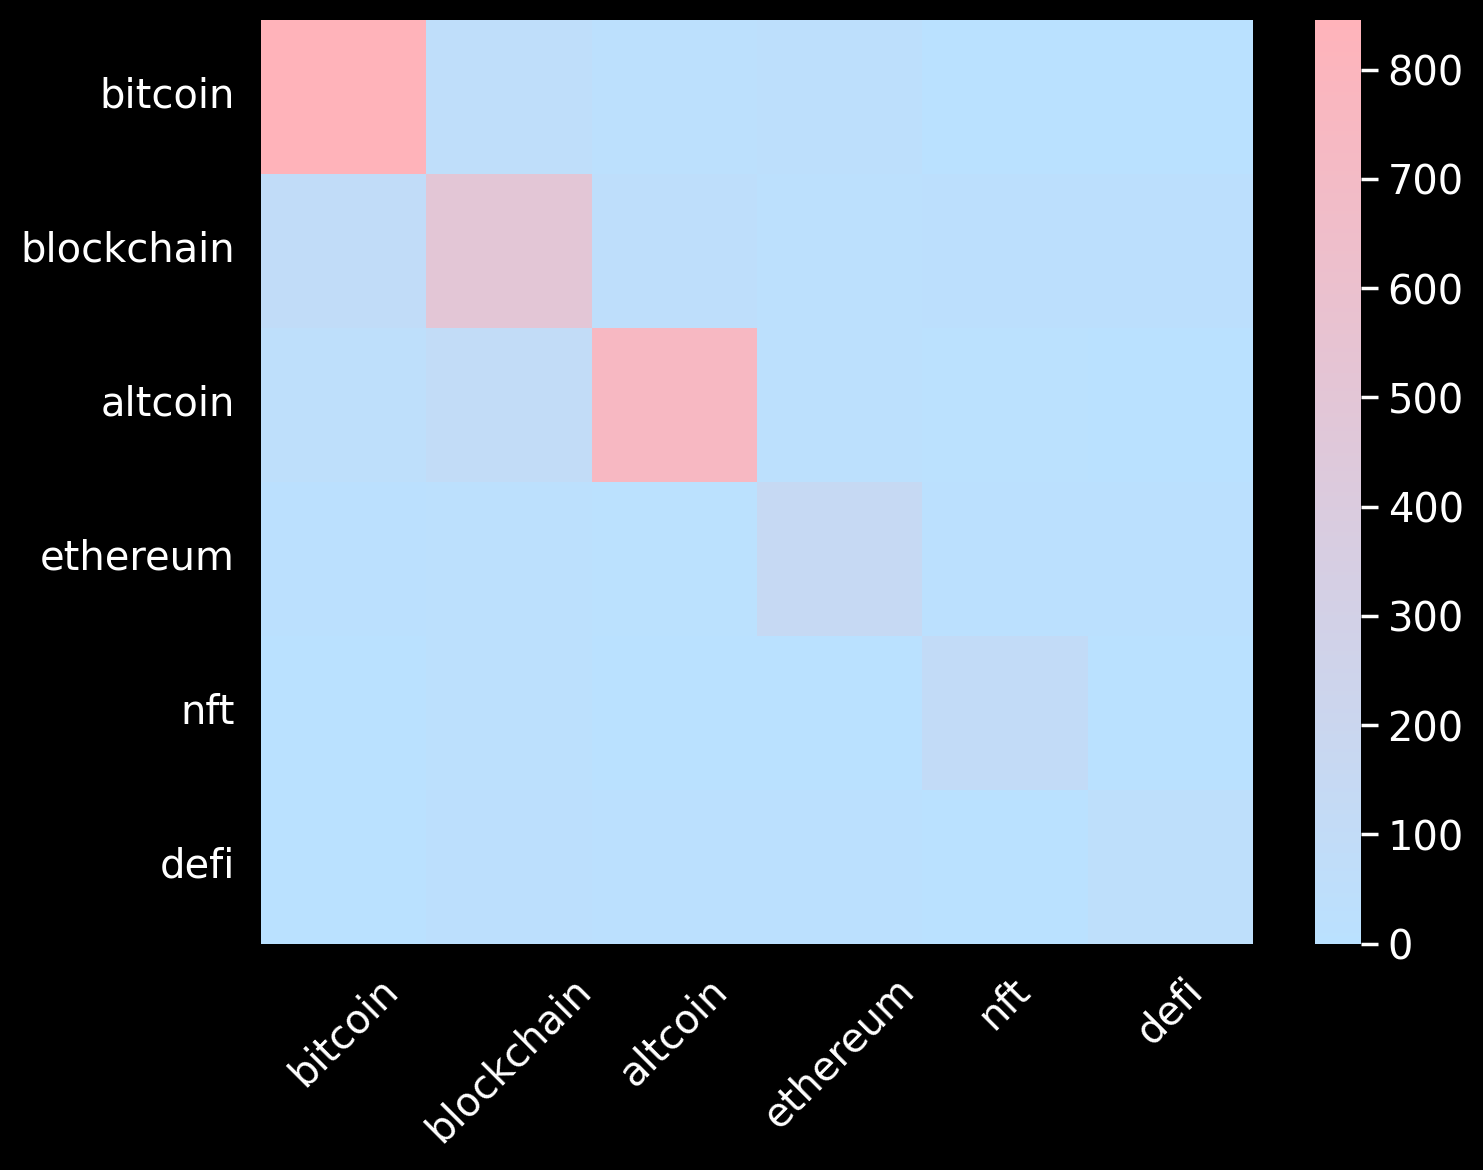

In [27]:
labels = predictions_df["true_subject"].unique().tolist()
cf_matrix = confusion_matrix(
    predictions_df["true_subject"], predictions_df["pred_subject"], labels=labels
)
_, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cf_matrix,
    cmap=cmap,
    ax=ax,
)
ax.set_yticklabels(labels, rotation=0)
ax.set_xticklabels(labels, rotation=45);

In [28]:
predictions_df[predictions_df["true_subject"] != predictions_df["pred_subject"]].head(
    n=10
)[["title", "text", "true_subject", "pred_subject"]]

,title,text,true_subject,pred_subject
2,Bitcoin Depot says SPAC merger will continue a...,The firm's revenue increased by 25.25% to $497...,blockchain,bitcoin
6,Poloniex prepares to resume withdrawals after ...,Poloniex says it will start resuming deposits ...,bitcoin,blockchain
18,"XRP, XLM, CFX, XDC and MASK rank among the top...",Most altcoins posted a below-par performance i...,bitcoin,defi
19,Today in Crypto: Germany's Financial Watchdog ...,"Source: AdobeStock / SergioGet your daily, bit...",altcoin,subject
20,Binance Abruptly Terminates Argentine Soccer A...,Binance has accused AFA of not fully meeting i...,blockchain,altcoin
21,Crypto and NFTs at F1: What are firms bringing...,Are crypto companies sponsoring F1 for the gli...,blockchain,nft
22,Coinbase Condemns SEC's 'Evasive Response' to ...,Coinbase has condemned the US SEC for its evas...,altcoin,blockchain
23,Metaverse platform The Nemesis launches flagsh...,Metaverses are said to bring to light new expe...,nft,blockchain
24,Web3 and Blockchain: Key Drivers of Gaming Inn...,"Web3 technology, as well as blockchain itself,...",nft,blockchain
29,Here’s how big food and beverage brands are us...,The key supporting factors for the market are ...,nft,blockchain


In [29]:
(predictions_df["true_sentiment"] == predictions_df["pred_sentiment"]).sum() / len(
    predictions_df
)

0.9130154639175257

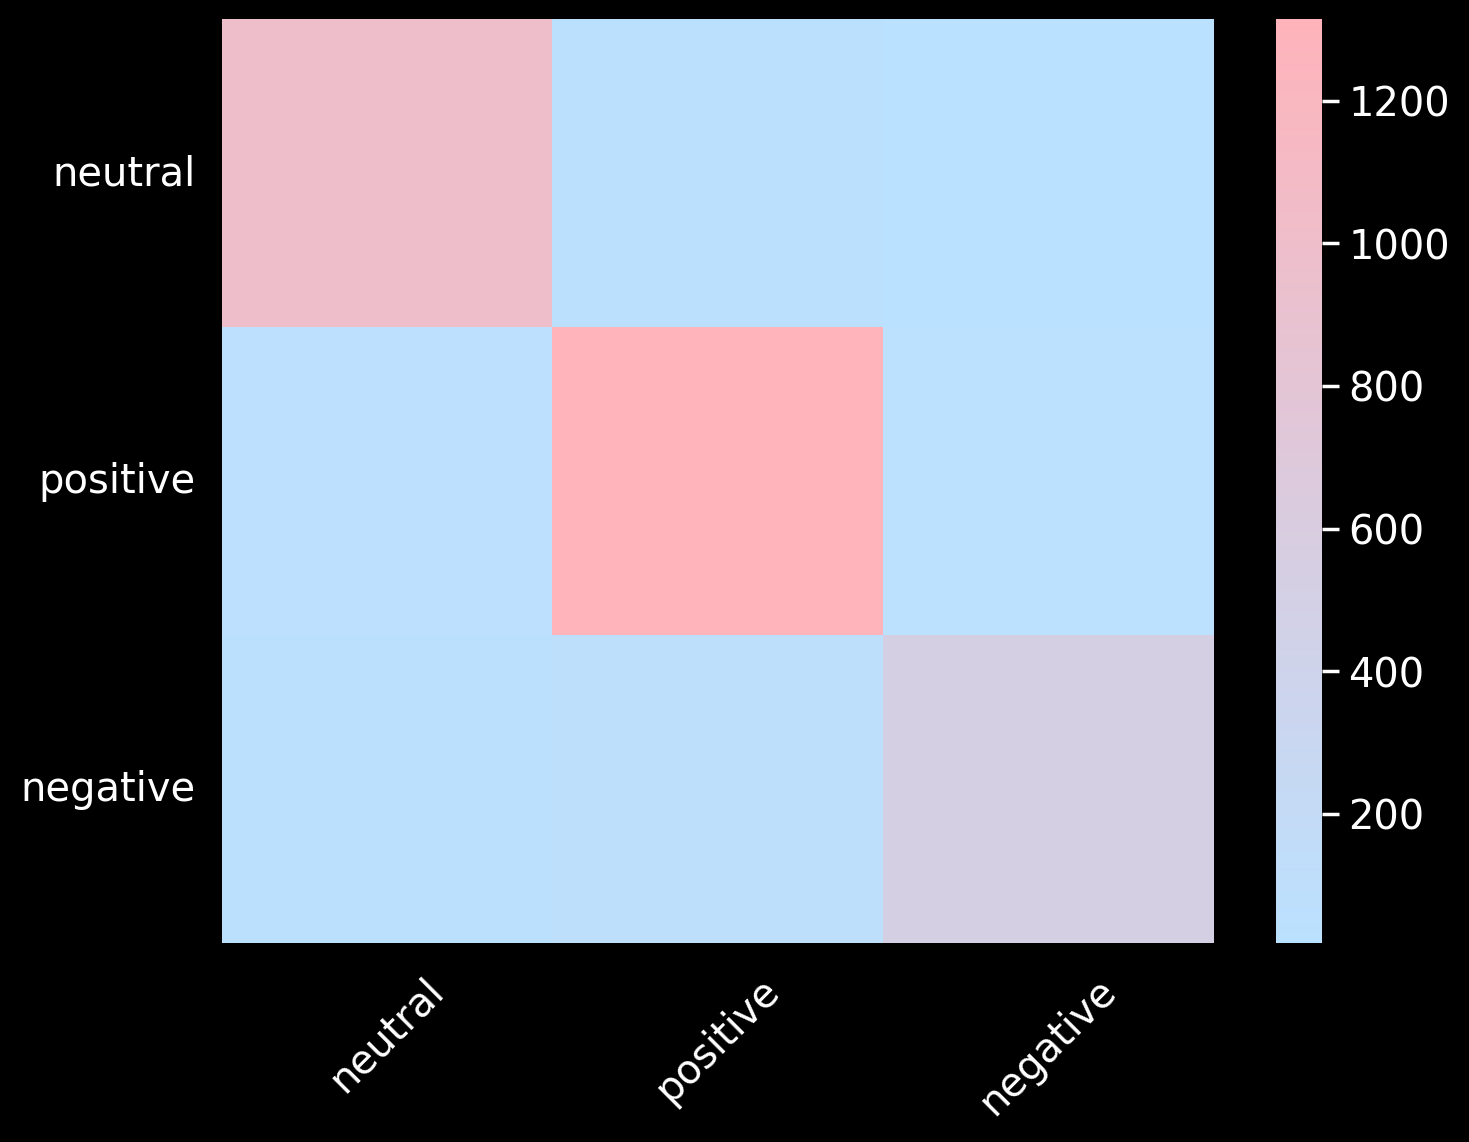

In [30]:
labels = predictions_df["true_sentiment"].unique().tolist()
cf_matrix = confusion_matrix(
    predictions_df["true_sentiment"], predictions_df["pred_sentiment"], labels=labels
)
_, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cf_matrix,
    cmap=cmap,
    ax=ax,
)
ax.set_yticklabels(labels, rotation=0)
ax.set_xticklabels(labels, rotation=45);

In [32]:
predictions_df[
    predictions_df["true_sentiment"] != predictions_df["pred_sentiment"]
].head(n=10)[["title", "text", "true_sentiment", "pred_sentiment"]]

,title,text,true_sentiment,pred_sentiment
16,Researcher envisions smart education system bu...,"According to the research, combining the techn...",positive,neutral
19,Today in Crypto: Germany's Financial Watchdog ...,"Source: AdobeStock / SergioGet your daily, bit...",neutral,sentiment
21,Crypto and NFTs at F1: What are firms bringing...,Are crypto companies sponsoring F1 for the gli...,neutral,positive
29,Here’s how big food and beverage brands are us...,The key supporting factors for the market are ...,positive,neutral
33,Moonbirds Collection Faces Criticism After Use...,Newly-launched NFT project Moonbirds has been ...,neutral,positive
45,Optimism Braces for $587M OP Token Unlock Amid...,The event will nearly double the circulating s...,neutral,positive
67,US State Regulators Grant Money Transmitter Li...,Institutional-focused crypto custody firm Bast...,negative,positive
75,Bitcoin Price Prediction: BTC Slips 3% as Cryp...,"Amidst fluctuating global events, Bitcoin is o...",negative,positive
83,Crypto sentiment index dips back to March ‘fea...,"Meanwhile, total liquidations have topped $280...",negative,positive
123,Axie Infinity devs release governance token fo...,"'SLP still on the ground LOL, if this coin sta...",positive,neutral


In [67]:
model.push_to_hub("akademiai/crypto-sentiment-news-tiny-llm", tokenizer=tokenizer, max_shard_size="5GB")
tokenizer.push_to_hub("akademiai/crypto-sentiment-news-tiny-llm")

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/107 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/akademiai/crypto-sentiment-news-tiny-llm/commit/b1138c07e64fbb2bede89e4a5d2f880d621ef67e', commit_message='Upload tokenizer', commit_description='', oid='b1138c07e64fbb2bede89e4a5d2f880d621ef67e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/akademiai/crypto-sentiment-news-tiny-llm', endpoint='https://huggingface.co', repo_type='model', repo_id='akademiai/crypto-sentiment-news-tiny-llm'), pr_revision=None, pr_num=None)